This notebook esimates FFH/FFE using image segmentation results from GSV pano images and corresponding depth maps, and conducts assessment of results using ground-truth data.

## Load modules
* Functions on geometry restoration are contained in the geometry.py module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import glob
from PIL import Image
from geometry import extract_feature_pixels_lowest_region, calculate_height_difference, estimate_FFH, estimate_FFE
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

## Set input folders of segmentation and depth images, ground-truth building points

In [3]:
# in_folder_predictions=r'D:\Wagga\GSV\Pano_clipped_predicted'
in_folder_predictions=r'D:\Launceston\GSV\Panos_clipped_predicted'
in_folder_depth=r'D:\Launceston\GSV\Depth_clipped'
building_point_file=r'D:\Launceston\GSV\Pano\LC_Final_meta.geojson'

## Read in ground-truth data

In [4]:
gdf=gpd.read_file(building_point_file)
gdf.head()

,EASTING,NORTHING,UFI,ZONE,DEM,LID,ADDRESS,SUBURB,POSTCODE,FEATURE_NA,...,Floor_height,pano_id,lat_c,lng_c,heading,pitch,roll,elevation,date,geometry
0,510962.988188,5.412541e+06,1002,15.0 Urban Mixed Use,2.697813,GNAF_GATAS702308914,13 PARK STREET,LAUNCESTON,7250,None,...,3.12,YNLZF16ubLTqrzW7SkVC3A,-41.438551,147.131445,5.841477,0.022252,6.228637,5.546635,2019-10,POINT (147.13123 -41.43862)
1,511021.688427,5.412248e+06,33,11.0 Inner Residential,4.208417,GNAF_GATAS702204375,293 BRISBANE STREET,LAUNCESTON,7250,None,...,3.33,Tz6NjkiBNSG1ge0lKjXhdg,-41.441052,147.131782,1.040822,0.037883,6.235322,5.922997,2023-09,POINT (147.13194 -41.44127)
2,511082.136711,5.412226e+06,31,11.0 Inner Residential,4.540370,GNAF_GATAS702478623,4 MIDDLE STREET,LAUNCESTON,7250,None,...,3.70,hANXkavpLZzicH-g505L6g,-41.441531,147.132669,0.957574,0.039241,0.022607,7.156610,2023-09,POINT (147.13266 -41.44146)
3,511068.760790,5.412219e+06,28,11.0 Inner Residential,5.212643,GNAF_GATAS702296648,6 MIDDLE STREET,LAUNCESTON,7250,None,...,3.37,kC4sWh0ZUf1E7nz52Fb9xA,-41.441585,147.132567,0.963067,0.051902,0.010492,7.739836,2023-09,POINT (147.1325 -41.44152)
4,511048.726805,5.412229e+06,26,11.0 Inner Residential,5.162260,GNAF_GATAS702290011,8 MIDDLE STREET,LAUNCESTON,7250,None,...,3.37,hw9Rgp7d5H3mb-WlVW-Z_A,-41.441662,147.132419,0.959565,0.034847,0.021449,8.384348,2023-09,POINT (147.13226 -41.44143)


## Read in segmentation image and corresponding depth map

In [5]:
prediction_files = glob.glob(os.path.join(in_folder_predictions,'*.png'))
prediction_file=prediction_files[0]
lbl_arr = np.asarray(Image.open(prediction_file))

In [6]:
pano_id=os.path.basename(prediction_file).split('.')[0]
print(pano_id)

YNLZF16ubLTqrzW7SkVC3A


In [7]:
depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
depth_arr=np.asarray(Image.open(depth_file))

Extract camera elevation:

In [8]:
elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values[0]
print(elev_camera)

5.546634674072266


## FFH/FFE Estimation
### Extract class masks and derive feature top/bottom
- segmentation class pixel values: 1:"foundation", 2:"front door", 3:"garage door", 4:"stairs"

In [9]:
# extract bottom pixels of foundation, stairs, front door and garage door
foundation_mask=(lbl_arr==1)
frontdoor_mask = (lbl_arr==2)
garagedoor_mask = (lbl_arr==3)
stairs_mask = (lbl_arr==4)
foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

# extract top pixels of foundation and stairs
foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")

### Calculate height difference between feature top/bottom and camera

In [10]:
H_img = depth_arr.shape[0]  # Height of the cropped panorama
delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)

### Calculate FFH/FFE

In [11]:
# calculate FFH
FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                   delta_foundation_bottom=delta_foundation_bottom,
                   delta_stairs_top=delta_stairs_top, 
                   delta_stairs_bottom=delta_stairs_bottom, 
                   delta_frontdoor_bottom=delta_frontdoor_bottom,
                   delta_garagedoor_bottom=delta_garagedoor_bottom)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): 0


In [12]:
# calculate FFE
FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                   delta_stairs_top=delta_stairs_top, 
                   delta_frontdoor_bottom=delta_frontdoor_bottom,
                   elev_camera=elev_camera)
print("Estimated First Floor Elevation (FFE):", FFE)

Estimated First Floor Elevation (FFE): 5.037187746080835


## Batch processing for all images
* This may take a while (more than an hour) depending on number of images to process.

In [13]:
FFH_all_predicted=[]
FFE_all_predicted=[]
pano_ids=[]
for prediction_file in prediction_files:
    # extract pano id
    pano_id=os.path.basename(prediction_file).split('.')[0]
    depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
    if os.path.exists(depth_file):
        pano_ids.append(pano_id)
        print('pano id: ',pano_id)
        # read in corresponding depth map
        lbl_arr = np.asarray(Image.open(prediction_file))
        depth_arr=np.asarray(Image.open(depth_file))
        
        # extract camera elevation
        elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values
        if elev_camera.size>=0:
            elev_camera=elev_camera[0]
        print(elev_camera)

        # extract bottom pixels of foundation, stairs, front door and garage door
        foundation_mask=(lbl_arr==1)
        frontdoor_mask = (lbl_arr==2)
        garagedoor_mask = (lbl_arr==3)
        stairs_mask = (lbl_arr==4)
        foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
        stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
        frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
        garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

        # extract top pixels of foundation and stairs
        foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
        stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")
        H_img = depth_arr.shape[0]  # Height of the cropped panorama

        # calculate height difference between feature top/bottom and camera
        delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
        delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
        delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
        delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
        delata_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
        delata_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)
        
        # calculate FFH
        FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                        delta_foundation_bottom=delta_foundation_bottom,
                        delta_stairs_top=delta_stairs_top, 
                        delta_stairs_bottom=delta_stairs_bottom, 
                        delta_frontdoor_bottom=delta_frontdoor_bottom,
                        delta_garagedoor_bottom=delta_garagedoor_bottom)
        # calculate FFE
        FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                    delta_stairs_top=delta_stairs_top, 
                    delta_frontdoor_bottom=delta_frontdoor_bottom,
                    elev_camera=elev_camera)
        print("Estimated First Floor Height (FFH):", FFH)
        print("Estimated First Floor Elevation (FFE):", FFE)
        FFE_all_predicted.append(FFE)
        FFH_all_predicted.append(FFH)
    else:
        print('no depth map exists, skipping...')

pano id:  YNLZF16ubLTqrzW7SkVC3A
5.546634674072266
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 5.037187746080835
pano id:  Tz6NjkiBNSG1ge0lKjXhdg
5.922996997833252
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 3.1523346976438735
pano id:  hANXkavpLZzicH-g505L6g
7.156610012054443
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 4.785730665663438
pano id:  kC4sWh0ZUf1E7nz52Fb9xA
7.7398362159729
Estimated First Floor Height (FFH): 0
Estimated First Floor Elevation (FFE): 6.112740711659185
pano id:  hw9Rgp7d5H3mb-WlVW-Z_A
8.384347915649414
Estimated First Floor Height (FFH): 0.4425729680613113
Estimated First Floor Elevation (FFE): 5.972574217062378
pano id:  OH5vAtnkf1rJ0PBWned9Gw
5.03416919708252
Estimated First Floor Height (FFH): 0.17499384283086084
Estimated First Floor Elevation (FFE): 1.684193856374018
pano id:  GvP_WNzTHiz53PaBhohUcw
3.513360500335693
Estimated First Floor Height (FFH): 0
Es

## Write estimated FFH/FFE back to building points file

In [15]:
gdf_updated=gdf.copy()
pano_id_to_FFH=dict(zip(pano_ids, FFH_all_predicted))
pano_id_to_FFE=dict(zip(pano_ids, FFE_all_predicted))
gdf_updated["FFH_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFH)
gdf_updated["FFE_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFE)

In [16]:
out_file=building_point_file.replace('.geojson','_FFH_GSV.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

## Regression analysis and accuracy assessment
### FFH

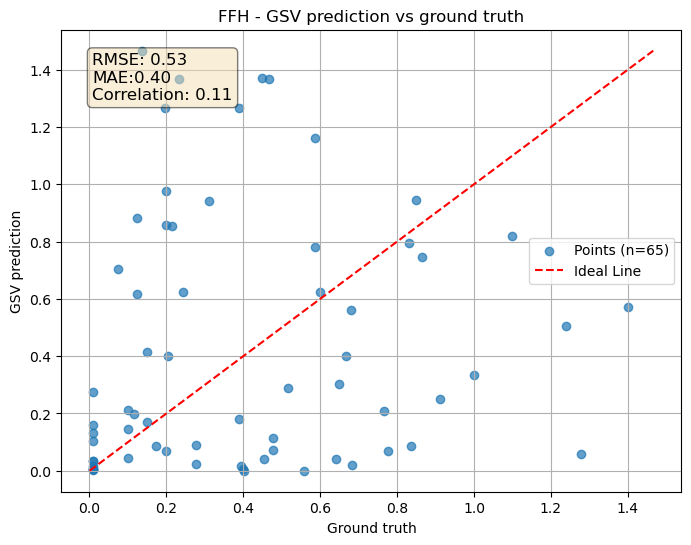

In [17]:
# filter out invalid prediction/groundtruth data
predicted_FFH=gdf_updated["FFH_GSV"]
gt_FFH=gdf_updated["Floor_height"]
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH)
valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)& (gt_FFH!=0.28)
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)
predicted_FFH = predicted_FFH[valid_indices]
gt_FFH = gt_FFH[valid_indices]

# Calculate RMSE and MAE
rmse = root_mean_squared_error(gt_FFH, predicted_FFH)
mae=mean_absolute_error(gt_FFH, predicted_FFH)
# Calculate Correlation Coefficient
correlation = np.corrcoef(gt_FFH, predicted_FFH)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFH, predicted_FFH, alpha=0.7, label=f'Points (n={len(predicted_FFH)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFH.min(), predicted_FFH.max()],[predicted_FFH.min(), predicted_FFH.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nMAE:{mae:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

### FFE

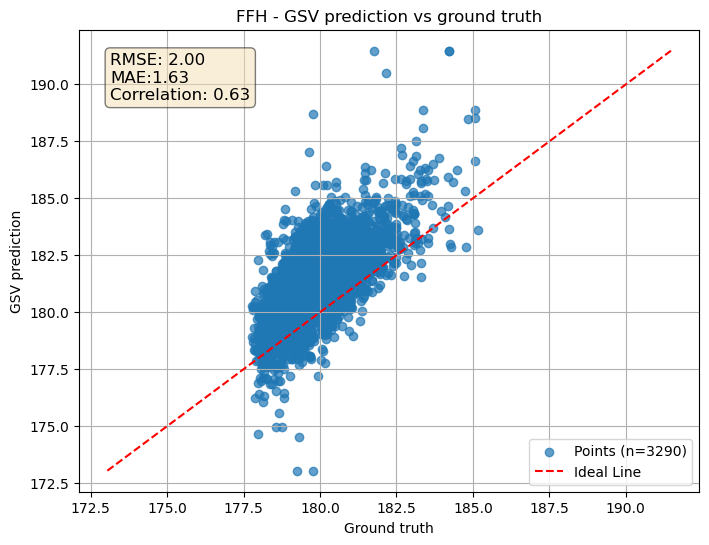

In [25]:
# filter out invalid prediction/groundtruth data
predicted_FFE=gdf_updated["FFE_GSV"]
gt_FFE=gdf_updated["Floor_Leve"]
valid_indices = ~np.isnan(predicted_FFE) & ~np.isnan(gt_FFE)
predicted_FFE = predicted_FFE[valid_indices]
gt_FFE = gt_FFE[valid_indices]

# Calculate RMSE and MAE
rmse_FFE = root_mean_squared_error(gt_FFE, predicted_FFE)
mae_FFE=mean_absolute_error(gt_FFE, predicted_FFE)
# Calculate Correlation Coefficient
correlation_FFE = np.corrcoef(gt_FFE, predicted_FFE)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFE, predicted_FFE, alpha=0.7, label=f'Points (n={len(predicted_FFE)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFE.min(), predicted_FFE.max()],[predicted_FFE.min(), predicted_FFE.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse_FFE:.2f}\nMAE:{mae_FFE:.2f}\nCorrelation: {correlation_FFE:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [23]:
len(predicted_FFH)

65